# Parámetros y carga de librerías

In [ ]:
# Parámetros
dias_empieza = 5000
dias_termina = -1
ticker = 'GGAL.BA'
Plotting = True

In [ ]:
!pip install yfinance
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta 
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 12000)
pd.set_option('display.width', 1000)

def descarga(ticker, fc_empieza, fc_termina):
  base = yf.download(ticker, start=fc_empieza, end=fc_termina)
  base = base[['Open', 'Adj Close', 'Volume', 'High', 'Low']]
  base.insert(loc=0, column='Ticker', value=ticker)
  base.reset_index(level=0, inplace=True)
  base.columns=['Date', 'Ticker', 'Open', 'Close', 'Volume', 'High', 'Low']
  base['fl_vela_alcista'] = np.where(base.Close > base.Open, 1, 0)
  return base

today = date.today()
fc_empieza = today + timedelta(days=(dias_empieza*-1))
fc_termina = today + timedelta(days=1)
pd.options.mode.chained_assignment = None
df = descarga(ticker, fc_empieza, fc_termina)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 522 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
[*********************100%***********************]  1 of 1 completed


In [ ]:
list(df.columns)

['Date', 'Ticker', 'Open', 'Close', 'Volume', 'High', 'Low', 'fl_vela_alcista']

# Agrego características

## Tendencias

In [ ]:
# Tendencias

wma_9 = df['Close'].rolling(9).apply(lambda x: x[::-1].cumsum().sum() * 2 / 9 / (9 + 1))
df['fl_tendencia_9_alcista'] = np.where((df['Close'] > wma_9), 1, 0)
wma_20 = df['Close'].rolling(20).apply(lambda x: x[::-1].cumsum().sum() * 2 / 20 / (20 + 1))
df['fl_tendencia_20_alcista'] = np.where((df['Close'] > wma_20), 1, 0)
wma_50 = df['Close'].rolling(50).apply(lambda x: x[::-1].cumsum().sum() * 2 / 50 / (50 + 1))
df['fl_tendencia_50_alcista'] = np.where((df['Close'] > wma_50), 1, 0)
wma_200 = df['Close'].rolling(200).apply(lambda x: x[::-1].cumsum().sum() * 2 / 200 / (200 + 1))
df['fl_tendencia_200_alcista'] = np.where((df['Close'] > wma_200), 1, 0)

precio_en_30 = []
precio_en_200 = []
for i, j in zip(df.Date, df.Close):
  pmax30 = df[df.Date <= i].tail(30).Close.max()
  pmin30 = df[df.Date <= i].tail(30).Close.min()
  pmax200 = df[df.Date <= i].tail(200).Close.max()
  pmin200 = df[df.Date <= i].tail(200).Close.min()
  try:
    precio_en_30.append(1 - (pmax30 - j)/(pmax30 - pmin30))
  except:
    precio_en_30.append(np.nan)
  try:
    precio_en_200.append(1 - (pmax200 - j)/(pmax200 - pmin200))
  except:
    precio_en_200.append(np.nan)

df['i_precio_en_30'] = precio_en_30
df['i_precio_en_200'] = precio_en_200

<ipython-input-4-3c591b42ce3c>:20: RuntimeWarning: invalid value encountered in double_scalars
  precio_en_30.append(1 - (pmax30 - j)/(pmax30 - pmin30))
<ipython-input-4-3c591b42ce3c>:24: RuntimeWarning: invalid value encountered in double_scalars
  precio_en_200.append(1 - (pmax200 - j)/(pmax200 - pmin200))


## Soportes y resistencias

In [ ]:
numero_lags = 5
rango_quiebre = 0.03

def save_data(dataset, df_all):
    df_all = pd.concat([dataset, df_all], axis=0)
    return df_all

def recorrido_soportes_resistencias(dataset, fecha_empieza_vigencia, valor_soporte, rango_quebrado, df_all, prueba_nro, Logging, clase):
  dataset = dataset[dataset.Date > fecha_empieza_vigencia]
  dataset['rango_quebrado_inicia'] = valor_soporte * (1-rango_quebrado)
  dataset['valor'] = valor_soporte
  dataset['rango_quebrado_termina'] = valor_soporte * (1+rango_quebrado)
  dataset['es_zona_prueba'] = np.where((dataset['Low'] < dataset['valor']) & (dataset['High'] > dataset['valor']), 1, 0)
  if clase == 's':
    dataset['es_zona_confirmacion'] = np.where((dataset['High'] > dataset['rango_quebrado_termina']), 1, 0)
    dataset['es_zona_quiebre'] = np.where((dataset['Low'] < dataset['rango_quebrado_inicia']), 1, 0)
  elif clase == 'r':
    dataset['es_zona_quiebre'] = np.where((dataset['High'] > dataset['rango_quebrado_termina']), 1, 0)
    dataset['es_zona_confirmacion'] = np.where((dataset['Low'] < dataset['rango_quebrado_inicia']), 1, 0)
  mascara_probado = (dataset.es_zona_prueba == 1)
  mascara_quebrado = (dataset.es_zona_quiebre == 1)
  if len(dataset[mascara_probado]) == 0 & len(dataset[mascara_quebrado]) == 0:
    resolucion = 'vigente'
    fecha_prueba = np.nan
    fecha_resolucion = np.nan
    print('La prueba número ', prueba_nro, 'nunca se realizó en la historia') if Logging else None
  elif len(dataset[mascara_probado]) == 0:
    resolucion = 'quebrado sin probarse nunca'
    fecha_prueba = np.nan
    fecha_resolucion = np.nan
    print('La prueba', prueba_nro, 'nunca se realizó, pero el valor fue quebrado') if Logging else None
  else:
    fecha_prueba = dataset[mascara_probado].iloc[0].Date
    resolucion = ''
    if len(dataset[mascara_quebrado]) > 0:
      fecha_quiebre = dataset[mascara_quebrado].iloc[0].Date
      if fecha_quiebre < fecha_prueba:      
        resolucion = 'quebrado'
        fecha_prueba = np.nan
        fecha_resolucion = fecha_quiebre
        print('La prueba', prueba_nro, 'fue quebrada antes de probarse') if Logging else None
    if resolucion != 'quebrado':
      print('La prueba número ', prueba_nro, 'empezó el día ', fecha_prueba, ' cuando el mínimo fue ', dataset[mascara_probado].iloc[0].Low, ' y el máximo fue ', dataset[mascara_probado].iloc[0].High) if Logging else None
      mascara_resuelto = ((dataset.Date > fecha_prueba)&(dataset.es_zona_confirmacion == 1))|((dataset.Date > fecha_prueba)&(dataset.es_zona_quiebre == 1))
      if len(dataset[mascara_resuelto]): # La prueba fue resuelta
        fecha_resolucion = dataset[mascara_resuelto].iloc[0].Date
        print('Fue resuelta el día ', fecha_resolucion, ' cuando el mínimo fue ', dataset[mascara_resuelto].iloc[0].Low, ' y el máximo fue ', dataset[mascara_resuelto].iloc[0].High) if Logging else None
        if (dataset[mascara_resuelto].iloc[0].es_zona_confirmacion == 1) & (dataset[mascara_resuelto].iloc[0].es_zona_quiebre == 1):
          resolucion = 'indeterminado por resolverse el mismo día'
          print('La prueba número ', prueba_nro, 'completó la historia sin ser determinada') if Logging else None
        elif dataset[mascara_resuelto].iloc[0].es_zona_confirmacion == 1:
          resolucion = 'probado'
          print('La prueba número ', prueba_nro, 'completó la historia probada el día ', fecha_resolucion) if Logging else None
        elif dataset[mascara_resuelto].iloc[0].es_zona_quiebre == 1:
          resolucion = 'quebrado'
          print('La prueba número ', prueba_nro, 'completó la historia quebrada el día ', fecha_resolucion) if Logging else None
      else:
        fecha_resolucion = np.nan
        resolucion = 'indeterminado por no resolverse nunca'
        print('No llegó a resolverse en el mes.') if Logging else None
  analisis_prueba_list = []
  analisis_prueba_list.append([ticker+str(round(valor_soporte,2)), ticker, valor_soporte, fecha_empieza_vigencia, prueba_nro, fecha_prueba, fecha_resolucion, resolucion])
  analisis_prueba = pd.DataFrame(analisis_prueba_list, columns = ["id_soporte", "ticker", "valor", "fecha_ingreso_vigencia", "nro_prueba_historia", "fecha_prueba", "fecha_resolucion", "tipo_resolucion"])
  analisis_prueba['fecha_prueba'] = pd.to_datetime(analisis_prueba['fecha_prueba'])
  analisis_prueba['fecha_resolucion'] = pd.to_datetime(analisis_prueba['fecha_resolucion'])
  df_all = save_data(df_all, analisis_prueba)
  if resolucion == 'probado':
    print('La prueba número ', prueba_nro, 'admite nuevas pruebas') if Logging else None
    prueba_nro = prueba_nro + 1
    dataset = dataset[dataset.Date > fecha_resolucion]
    return recorrido_soportes_resistencias(dataset, fecha_empieza_vigencia, valor_soporte, rango_quebrado, df_all, prueba_nro, Logging, clase)
  else:
    return df_all

def calculo_historia(dataset, lags, rq, l):
  global puntos_soporte, fechas_soporte, fechas_vigencia_soporte, puntos_resistencia, fechas_resistencia, fechas_vigencia_resistencia
  i = 1
  while i < (lags+1): # Genera ventanas alrededor para analizar si es soporte
      colname = 'l%sb' % (i)                                                  
      dataset[colname] = round(dataset['Close'].shift(i),2)
      colname = 'l%sf' % (i)                                                  
      dataset[colname] = round(dataset['Close'].shift(-i),2)
      i = i + 1
  x = np.arange(len(dataset.Date))
  dataset['minb'] = round(dataset.filter(regex=("l.*b")).min(axis=1),2)
  dataset['minf'] = round(dataset.filter(regex=("l.*f")).min(axis=1),2)
  dataset['maxb'] = round(dataset.filter(regex=("l.*b")).max(axis=1),2)
  dataset['maxf'] = round(dataset.filter(regex=("l.*f")).max(axis=1),2)
  dataset['Soporte'] = np.where((dataset.index > lags) & (dataset['Close']<dataset['minb']) & (dataset['Close']<dataset['minf']), 1, 0)
  dataset['Soporte'] = np.where((dataset.index > (dataset.shape[0] - lags)), 0 , dataset.Soporte * dataset['Close'])
  dataset['Resistencia'] = np.where((dataset.index > lags) & (dataset['Close']>dataset['maxb']) & (dataset['Close']>dataset['maxf']), 1, 0)
  dataset['Resistencia'] = np.where((dataset.index > (dataset.shape[0] - lags)), 0 , dataset.Resistencia * dataset['Close'])
  dataset = dataset[['Date', 'Ticker', 'Close', 'Low', 'High', 'Soporte', 'Resistencia']]
  dataset['Date_vigencia'] = dataset.Date.shift(-lags)
  dataset.replace(0, np.nan, inplace=True)
  puntos_soporte = dataset[dataset.Soporte > 0]['Soporte'].to_numpy() # Lista de soportes
  fechas_soporte = dataset[dataset.Soporte > 0]['Date'].to_numpy() # Lista de fechas de soporte
  fechas_vigencia_soporte = dataset[dataset.Soporte > 0]['Date_vigencia'].to_numpy() # Lista de fechas de soporte
  print('EMPIEZA ANÁLISIS DE SOPORTES') if l else None
  dataset_all_soportes = pd.DataFrame()
  i = 0
  while i < len(puntos_soporte):  # Recorre la lista de soportes
    dataset_all_soportes = recorrido_soportes_resistencias(dataset, fechas_vigencia_soporte[i], puntos_soporte[i], rq, dataset_all_soportes, 1, Logging=l, clase='s')
    i = i + 1
  print('EMPIEZA ANÁLISIS DE RESISTENCIAS') if l else None
  puntos_resistencia = dataset[dataset.Resistencia > 0]['Resistencia'].to_numpy() # Lista de resistencia
  fechas_resistencia = dataset[dataset.Resistencia > 0]['Date'].to_numpy() # Lista de fechas de resistencia
  fechas_vigencia_resistencia = dataset[dataset.Resistencia > 0]['Date_vigencia'].to_numpy() # Lista de fechas de soporte
  dataset_all_resistencias = pd.DataFrame()
  i = 0
  while i < len(puntos_resistencia):  # Recorre la lista de resistencia
    print('ANALIZO EL PUNTO ', puntos_resistencia[i], ' DEL ', fechas_resistencia[i], ' QUE ENTRARÍA EN VIGENCIA EL ', fechas_vigencia_resistencia[i]) if l else None
    dataset_all_resistencias = recorrido_soportes_resistencias(dataset, fechas_vigencia_resistencia[i], puntos_resistencia[i], rq, dataset_all_resistencias, 1, Logging=l, clase='r')
    i = i + 1
  return dataset_all_soportes, dataset_all_resistencias

def seleccion_linea(dataset, fecha, precio, clase):
  mascara_iniciados_antes = (dataset.fecha_ingreso_vigencia < fecha)
  mascara_vigentes_hoy = (dataset.tipo_resolucion == 'vigente')
  mascara_quebrados_despues = ((dataset.tipo_resolucion == 'quebrado') & (dataset.fecha_resolucion > fecha))|((dataset.tipo_resolucion == 'indeterminado por resolverse el mismo día') & (dataset.fecha_resolucion > fecha))
  vigentes = dataset[mascara_iniciados_antes & (mascara_vigentes_hoy|mascara_quebrados_despues)].sort_values(by=['fecha_ingreso_vigencia'])
  if clase == 's':
    try:
      valor = vigentes.iloc[vigentes['valor'].argmax()].valor
      pruebas = vigentes.iloc[vigentes['valor'].argmax()].nro_prueba_historia
      antiguedad = (fecha - (vigentes.iloc[vigentes['valor'].argmax()].fecha_ingreso_vigencia)).days
      return valor, pruebas, antiguedad
    except:
      return np.nan, np.nan, np.nan
  elif clase == 'r':
    try:
      valor = vigentes.iloc[vigentes['valor'].argmin()].valor
      pruebas = vigentes.iloc[vigentes['valor'].argmin()].nro_prueba_historia
      antiguedad = (fecha - (vigentes.iloc[vigentes['valor'].argmin()].fecha_ingreso_vigencia)).days
      return valor, pruebas, antiguedad
    except:
      return np.nan, np.nan, np.nan

datasets_soportes_resistencias = {}

periodos_sr = [5, 10, 20]

for num_lags in periodos_sr:
  df_soportes, df_resistencias = calculo_historia(df, num_lags, rango_quiebre, l=False)
  df = df[df.columns.drop(list(df.filter(regex='l.*b|l.*f|minb|minf|maxb|maxf|Soporte|Resistencia')))]
  
  lista_soportes_diarios = [seleccion_linea(df_soportes, f, p, 's') for f, p in zip(df['Date'], df['Close'])]
  df['soporte_%s_valor' % (num_lags)] = [a_tuple[0] for a_tuple in lista_soportes_diarios]
  df['soporte_%s_numero_pruebas' % (num_lags)] = [a_tuple[1] for a_tuple in lista_soportes_diarios]
  df['soporte_%s_dias_antiguedad' % (num_lags)] = [a_tuple[2] for a_tuple in lista_soportes_diarios]

  lista_resistencias_diarias  = [seleccion_linea(df_resistencias, f, p, 'r') for f, p in zip(df['Date'], df['Close'])]
  df['resistencia_%s_valor' % (num_lags)] = [a_tuple[0] for a_tuple in lista_resistencias_diarias]
  df['resistencia_%s_numero_pruebas' % (num_lags)] = [a_tuple[1] for a_tuple in lista_resistencias_diarias]
  df['resistencia_%s_dias_antiguedad' % (num_lags)] = [a_tuple[2] for a_tuple in lista_resistencias_diarias]
  datasets_soportes_resistencias["df_soportes_{0}".format(num_lags)] = df_soportes
  datasets_soportes_resistencias["df_resistencias_{0}".format(num_lags)] = df_resistencias

df = df[df.columns.drop(list(df.filter(regex='l(.*)b')))]
df = df[df.columns.drop(list(df.filter(regex='l(.*)f')))]
df = df[df.columns.drop(list(df.filter(regex='maxf|maxb|minf|minb')))]

for num_lags in periodos_sr:
  df['ch_dist_a_resistencia_%s' % (num_lags)] = df['resistencia_%s_valor' % (num_lags)]/df['Close']
  df['ch_dist_a_soporte_%s' % (num_lags)] = df['soporte_%s_valor' % (num_lags)]/df['Close']

# Tomando los soportes del punto anterior, se identifican lineas que pasaron por tres puntos (un punto de origen, uno con el que arma la pendiente y otro con el que confirma). Con eso se genera un soporte dinámico o resistencia dinámica.
# Para cada día se buscan los soportes y resistencias dinámicos vigentes, independientemente de pruebas o quiebres anteriores.

vigentes = df_soportes[(df_soportes.tipo_resolucion != 'probado')&(df_soportes.fecha_ingreso_vigencia.notnull())]
vigentes['indice'] = [df[df.Date == x].index[0] - numero_lags for x in vigentes['fecha_ingreso_vigencia']]
vigentes['fecha'] = [df.loc[x]['Date'] for x in vigentes['indice']]
soportes_dinamicos = pd.DataFrame(columns = ['fecha_previa_0', 'fecha_previa_1', 'fecha_ingreso_vigencia', 'fecha', 'indice', 'valor', 'pendiente'])

def seleccion_linea_dinamica(dataset, fecha, precio, clase):
  mascara_iniciados_antes = (dataset.fecha_ingreso_vigencia < fecha)
  vigentes = dataset[(mascara_iniciados_antes)].sort_values(by=['fecha_ingreso_vigencia'])
  vigentes['indice_fin'] = df[df.Date == fecha].index.values[0]
  vigentes['valor_potencial'] = vigentes['valor'] + vigentes['pendiente'] * (vigentes['indice_fin']-vigentes['indice'])
  if clase == 's':
    vigentes = vigentes[vigentes.valor_potencial < precio]
    try:
      return vigentes['valor_potencial'].max()
    except:
      return np.nan
  elif clase == 'r':
    vigentes = vigentes[vigentes.valor_potencial > precio]
    try:
      return vigentes['valor_potencial'].min()
    except:
      return np.nan

i = 0
while i < len(vigentes):
  j = i + 1
  while j < len(vigentes):
    pendiente = (vigentes.iloc[j,:]['valor'] - vigentes.iloc[i,:]['valor'])/(vigentes.iloc[j,:]['indice'] - vigentes.iloc[i,:]['indice'])
    k = j + 1
    while k < len(vigentes):
      if (vigentes.iloc[j,:]['valor'] * 1.025 > (vigentes.iloc[j,:]['valor'] + pendiente * (vigentes.iloc[k,:]['indice'] - vigentes.iloc[j,:]['indice']))) & (vigentes.iloc[j,:]['valor'] * 0.975 < (vigentes.iloc[j,:]['valor'] + pendiente * (vigentes.iloc[k,:]['indice'] - vigentes.iloc[j,:]['indice']))):
        if pendiente > vigentes.iloc[k,:]['valor'] * 0.001:
          soportes_dinamicos = soportes_dinamicos.append(pd.Series([vigentes.iloc[i,:]['fecha_ingreso_vigencia'], vigentes.iloc[j,:]['fecha_ingreso_vigencia'], vigentes.iloc[k,:]['fecha_ingreso_vigencia'], vigentes.iloc[k,:]['fecha'], vigentes.iloc[k,:]['indice'], vigentes.iloc[k,:]['valor'], pendiente], index = soportes_dinamicos.columns), ignore_index=True)
      k = k + 1
    j = j + 1
  i = i + 1

df['soporte_dinamico_valor'] = [seleccion_linea_dinamica(soportes_dinamicos, f, p, 's') for f, p in zip(df['Date'], df['Close'])]
df['ch_dist_a_soporte_dinamico'] = df['soporte_dinamico_valor']/df['Close']

vigentes = df_resistencias[(df_resistencias.tipo_resolucion != 'probado')&(df_resistencias.fecha_ingreso_vigencia.notnull())]
vigentes['indice'] = [df[df.Date == x].index[0] - numero_lags for x in vigentes['fecha_ingreso_vigencia']]
vigentes['fecha'] = [df.loc[x]['Date'] for x in vigentes['indice']]
resistencias_dinamicas = pd.DataFrame(columns = ['fecha_previa_0', 'fecha_previa_1', 'fecha_ingreso_vigencia', 'fecha', 'indice', 'valor', 'pendiente'])

i = 0
while i < len(vigentes):
  j = i + 1
  while j < len(vigentes):
    pendiente = (vigentes.iloc[j,:]['valor'] - vigentes.iloc[i,:]['valor'])/(vigentes.iloc[j,:]['indice'] - vigentes.iloc[i,:]['indice'])
    k = j + 1
    while k < len(vigentes):
      if (vigentes.iloc[j,:]['valor'] * 1.035 > (vigentes.iloc[j,:]['valor'] + pendiente * (vigentes.iloc[k,:]['indice'] - vigentes.iloc[j,:]['indice']))) & (vigentes.iloc[j,:]['valor'] * 0.965 < (vigentes.iloc[j,:]['valor'] + pendiente * (vigentes.iloc[k,:]['indice'] - vigentes.iloc[j,:]['indice']))):
        if pendiente > vigentes.iloc[k,:]['valor'] * 0.001:
          resistencias_dinamicas = resistencias_dinamicas.append(pd.Series([vigentes.iloc[i,:]['fecha_ingreso_vigencia'], vigentes.iloc[j,:]['fecha_ingreso_vigencia'], vigentes.iloc[k,:]['fecha_ingreso_vigencia'], vigentes.iloc[k,:]['fecha'], vigentes.iloc[k,:]['indice'],  vigentes.iloc[k,:]['valor'], pendiente], index = resistencias_dinamicas.columns), ignore_index=True)
      k = k + 1
    j = j + 1
  i = i + 1

df['resistencia_dinamica_valor'] = [seleccion_linea_dinamica(resistencias_dinamicas, f, p, 'r') for f, p in zip(df['Date'], df['Close'])]
df['ch_dist_a_resistencia_dinamica'] = df['resistencia_dinamica_valor']/df['Close']

In [ ]:
list(df.columns)

['Date',
 'Ticker',
 'Open',
 'Close',
 'Volume',
 'High',
 'Low',
 'fl_vela_alcista',
 'fl_tendencia_9_alcista',
 'fl_tendencia_20_alcista',
 'fl_tendencia_50_alcista',
 'fl_tendencia_200_alcista',
 'i_precio_en_30',
 'i_precio_en_200',
 'soporte_5_valor',
 'soporte_5_numero_pruebas',
 'soporte_5_dias_antiguedad',
 'resistencia_5_valor',
 'resistencia_5_numero_pruebas',
 'resistencia_5_dias_antiguedad',
 'soporte_10_valor',
 'soporte_10_numero_pruebas',
 'soporte_10_dias_antiguedad',
 'resistencia_10_valor',
 'resistencia_10_numero_pruebas',
 'resistencia_10_dias_antiguedad',
 'soporte_20_valor',
 'soporte_20_numero_pruebas',
 'soporte_20_dias_antiguedad',
 'resistencia_20_valor',
 'resistencia_20_numero_pruebas',
 'resistencia_20_dias_antiguedad',
 'ch_dist_a_resistencia_5',
 'ch_dist_a_soporte_5',
 'ch_dist_a_resistencia_10',
 'ch_dist_a_soporte_10',
 'ch_dist_a_resistencia_20',
 'ch_dist_a_soporte_20',
 'soporte_dinamico_valor',
 'ch_dist_a_soporte_dinamico',
 'resistencia_dinamica

## Fibonacci y Elliott

In [ ]:
# Se toman todos los soportes y resistencias construidos previamente. Se busca genera el wma de [n] períodos y se busca la relación entre el precio y esa wma. Cuando esa relación se invierte se dice que hay reversión.
# Además, si esa reversión surge de una tendencia anterior duradera, es decir que en los [n] ruedas previas no hubo cambio de tendencia, decimos que esa tendencia terminada fue importante como para encontrar un movimiento del que podría haber retroceso.
# Entonces, si la tendencia larga terminada es alcista (bajista), buscamos el último punto de soporte anterior al comienzo de la tendencia y el último punto de resistencia anterior al fin de la tendencia, entre los dos armamos el movimiento de fibonacci y planteamos los puntos de retroceso, duraderos hasta la próxima vez que se repite lo mismo.
# Durante todo el momento en el que el retroceso dura, buscamos en caso de que sea un retroceso bajista (alcista) el primer soporte (resistencia), y desde ahí usamos las mismas proporciones de fibonacci para armar las extensiones.
# Se probó con n = 12 y se encontró una buena identificación del cambio de tendencias

# PARÁMETROS
n = 18
df_soportes, df_resistencias = calculo_historia(df, 7, rango_quiebre, l=False) # Recomputo soportes y resistencias
df = df[df.columns.drop(list(df.filter(regex='l(.*)b')))]
df = df[df.columns.drop(list(df.filter(regex='l(.*)f')))]
df = df[df.columns.drop(list(df.filter(regex='maxf|maxb|minf|minb|Soporte|Resistencia')))]

df_fibo = df[['Date', 'Close', 'High', 'Low']].copy()

wma = df_fibo['Close'].rolling(n).apply(lambda x: x[::-1].cumsum().sum() * 2 / n / (n + 1))
df_fibo['reversion'] = np.where(df['Close'] > wma, 'alcista', 'bajista')
df_fibo = df_fibo[df_fibo['reversion'] != df_fibo['reversion'].shift(1)]
df_fibo['indice'] = df_fibo.index
df_fibo['inicio_ciclo_anterior'] = df_fibo['Date'].shift(1)
df_fibo['duracion_ciclo_anterior'] = (df_fibo['indice'] - df_fibo['indice'].shift(1))
df_fibo = df_fibo[df_fibo.duracion_ciclo_anterior>n]
df_fibo['inicio_ciclo_posterior'] = df_fibo['Date'].shift(-1)
df_fibo['tipo_movimiento'] = np.where(df_fibo['reversion'] == 'bajista', 'alcista', 'bajista')
df_fibo['inicio_movimiento'] = np.nan
df_fibo['fin_movimiento'] = np.nan
df_fibo['precio_fin_movimiento'] = np.nan

df_rf_global = df[df.Date <= df_fibo[2:]['Date'].iloc[0]].copy()
#print('Genero el df local, de fechas anteriores a ', df_fibo[df_fibo.duracion_ciclo_anterior>n][2:]['Date'].iloc[0])

df_rf_global['rf_23'] = np.nan
df_rf_global['rf_38.2'] = np.nan
df_rf_global['rf_50'] = np.nan
df_rf_global['rf_61.8'] = np.nan
df_rf_global['rf_76.8'] = np.nan
df_rf_global['rf_100'] = np.nan
fechas_soporte_pd = pd.to_datetime(fechas_soporte)
fechas_resistencia_pd = pd.to_datetime(fechas_resistencia)

lst = []
for index, row in df_fibo[2:].iterrows():
  #print('Genero mi df local, de fechas posteriores a ', row['Date'], ' y anteriores a ', row['inicio_ciclo_posterior'])
  
  if row['reversion'] == 'bajista': # Si la reversión es bajista, es porque el movimiento fue ascendente, desde un soporte a una resistencia
    movimiento = 'alcista'
    fechas_soporte_vigentes_inicio = fechas_soporte_pd[fechas_soporte_pd < row['inicio_ciclo_anterior']]
    fecha_empieza_movimiento = fechas_soporte_vigentes_inicio[-1]
    precio_empieza_movimiento = puntos_soporte[len(fechas_soporte_vigentes_inicio)-1]

    fechas_resistencia_vigentes_termina = fechas_resistencia_pd[(fechas_resistencia_pd < row['Date'])] #) & (fechas_resistencia_pd>fecha_empieza_movimiento)]
    fecha_termina_movimiento = fechas_resistencia_vigentes_termina[-1]
    precio_termina_movimiento = puntos_resistencia[len(fechas_resistencia_vigentes_termina)-1]

    df_fibo.loc[index, 'inicio_movimiento'] = fecha_empieza_movimiento
    df_fibo.loc[index, 'fin_movimiento'] = fecha_termina_movimiento
    df_fibo.loc[index, 'precio_fin_movimiento'] = precio_termina_movimiento

    df_rf_local = df[(df.Date >= row['Date']) & ((df.Date < row['inicio_ciclo_posterior'])|(row['inicio_ciclo_posterior'] is pd.NaT))]
    df_rf_local['rf_tipo'] = 'Bajista'
    df_rf_local['rf_23'] = precio_termina_movimiento - (precio_termina_movimiento - precio_empieza_movimiento) * 0.23
    df_rf_local['rf_38.2'] = precio_termina_movimiento - (precio_termina_movimiento - precio_empieza_movimiento) * 0.382
    df_rf_local['rf_50'] = precio_termina_movimiento - (precio_termina_movimiento - precio_empieza_movimiento) * 0.50
    df_rf_local['rf_61.8'] = precio_termina_movimiento - (precio_termina_movimiento - precio_empieza_movimiento) * 0.618
    df_rf_local['rf_76.8'] = precio_termina_movimiento - (precio_termina_movimiento - precio_empieza_movimiento) * 0.768
    df_rf_local['rf_100'] = precio_termina_movimiento - (precio_termina_movimiento - precio_empieza_movimiento) * 1

    try:
      df_soportes_validos = df_soportes[(df_soportes['f']>df_rf_local['Date'].iloc[0])&(df_soportes['f']<df_rf_local['Date'].iloc[-1])&(df_soportes['p']<precio_termina_movimiento)]
      extension_fecha = df_soportes_validos['f'].iloc[0]
      extension_precio = df_soportes_validos['p'].iloc[0]

      df_no_ef_local = df_rf_local[df_rf_local.Date < extension_fecha]

      df_no_ef_local['ef_23'] = np.nan
      df_no_ef_local['ef_38.2'] = np.nan
      df_no_ef_local['ef_50'] = np.nan
      df_no_ef_local['ef_61.8'] = np.nan
      df_no_ef_local['ef_76.8'] = np.nan
      df_no_ef_local['ef_100'] = np.nan

      df_ef_local = df_rf_local[df_rf_local.Date >= extension_fecha]
      df_ef_local['ef_23'] = extension_precio + (precio_termina_movimiento - precio_empieza_movimiento) * 0.23
      df_ef_local['ef_38.2'] = extension_precio + (precio_termina_movimiento - precio_empieza_movimiento) * 0.382
      df_ef_local['ef_50'] = extension_precio + (precio_termina_movimiento - precio_empieza_movimiento) * 0.50
      df_ef_local['ef_61.8'] = extension_precio + (precio_termina_movimiento - precio_empieza_movimiento) * 0.618
      df_ef_local['ef_76.8'] = extension_precio + (precio_termina_movimiento - precio_empieza_movimiento) * 0.768
      df_ef_local['ef_100'] = extension_precio + (precio_termina_movimiento - precio_empieza_movimiento) * 1

      df_rf_local = pd.concat([df_no_ef_local, df_ef_local], axis=0)

    except:
      df_rf_local['ef_23'] = np.nan
      df_rf_local['ef_38.2'] = np.nan
      df_rf_local['ef_50'] = np.nan
      df_rf_local['ef_61.8'] = np.nan
      df_rf_local['ef_76.8'] = np.nan
      df_rf_local['ef_100'] = np.nan


  if row['reversion'] == 'alcista': # Si la reversión es alcista, es porque el movimiento fue descendente, desde una resistencia a un soporte
    movimiento = 'bajista'
    fechas_resistencia_vigentes_inicio = fechas_resistencia_pd[fechas_resistencia_pd < row['inicio_ciclo_anterior']]
    fecha_empieza_movimiento = fechas_resistencia_vigentes_inicio[-1]
    row['inicio_movimiento'] = fecha_empieza_movimiento
    precio_empieza_movimiento = puntos_resistencia[len(fechas_resistencia_vigentes_inicio)-1]

    fechas_soporte_vigentes_termina = fechas_soporte_pd[fechas_soporte_pd < row['Date']]# & (fechas_resistencia_pd>fecha_empieza_movimiento)]
    fecha_termina_movimiento = fechas_soporte_vigentes_termina[-1]
    precio_termina_movimiento = puntos_soporte[len(fechas_soporte_vigentes_termina)-1]

    df_fibo.loc[index, 'inicio_movimiento'] = fecha_empieza_movimiento
    df_fibo.loc[index, 'fin_movimiento'] = fecha_termina_movimiento
    df_fibo.loc[index, 'precio_fin_movimiento'] = precio_termina_movimiento

    df_rf_local = df[(df.Date >= row['Date']) & ((df.Date < row['inicio_ciclo_posterior'])|(row['inicio_ciclo_posterior'] is pd.NaT))]
    df_rf_local['rf_tipo'] = 'Alcista'
    df_rf_local['rf_23'] = precio_termina_movimiento + (precio_empieza_movimiento - precio_termina_movimiento) * 0.23
    df_rf_local['rf_38.2'] = precio_termina_movimiento + (precio_empieza_movimiento - precio_termina_movimiento) * 0.382
    df_rf_local['rf_50'] = precio_termina_movimiento + (precio_empieza_movimiento - precio_termina_movimiento) * 0.50
    df_rf_local['rf_61.8'] = precio_termina_movimiento + (precio_empieza_movimiento - precio_termina_movimiento) * 0.618
    df_rf_local['rf_76.8'] = precio_termina_movimiento + (precio_empieza_movimiento - precio_termina_movimiento) * 0.768
    df_rf_local['rf_100'] = precio_termina_movimiento + (precio_empieza_movimiento - precio_termina_movimiento) * 1

    try:
      df_resistencias_validos = df_resistencias[(df_resistencias['f']>df_rf_local['Date'].iloc[0])&(df_resistencias['f']<df_rf_local['Date'].iloc[-1])&(df_resistencias['p']<precio_termina_movimiento)]
      extension_fecha = df_resistencias_validos['f'].iloc[0]
      extension_precio = df_resistencias_validos['p'].iloc[0]

      df_no_ef_local = df_rf_local[df_rf_local.Date < extension_fecha].copy()
      df_no_ef_local['ef_23'] = np.nan
      df_no_ef_local['ef_38.2'] = np.nan
      df_no_ef_local['ef_50'] = np.nan
      df_no_ef_local['ef_61.8'] = np.nan
      df_no_ef_local['ef_76.8'] = np.nan
      df_no_ef_local['ef_100'] = np.nan

      df_ef_local = df_rf_local[df_rf_local.Date >= extension_fecha].copy()
      df_ef_local['ef_23'] = extension_precio - (precio_empieza_movimiento - precio_termina_movimiento) * 0.23
      df_ef_local['ef_38.2'] = extension_precio - (precio_empieza_movimiento - precio_termina_movimiento) * 0.382
      df_ef_local['ef_50'] = extension_precio - (precio_empieza_movimiento - precio_termina_movimiento) * 0.50
      df_ef_local['ef_61.8'] = extension_precio - (precio_empieza_movimiento - precio_termina_movimiento) * 0.618
      df_ef_local['ef_76.8'] = extension_precio - (precio_empieza_movimiento - precio_termina_movimiento) * 0.768
      df_ef_local['ef_100'] = extension_precio - (precio_empieza_movimiento - precio_termina_movimiento) * 1

      df_rf_local = pd.concat([df_no_ef_local, df_ef_local], axis=0)

    except:
      df_rf_local['ef_23'] = np.nan
      df_rf_local['ef_38.2'] = np.nan
      df_rf_local['ef_50'] = np.nan
      df_rf_local['ef_61.8'] = np.nan
      df_rf_local['ef_76.8'] = np.nan
      df_rf_local['ef_100'] = np.nan

  lst.append([ticker, movimiento, fecha_empieza_movimiento, precio_empieza_movimiento, fecha_termina_movimiento, precio_termina_movimiento, row['Date']])

  df_rf_global = df_rf_global.append(df_rf_local) # Falta que appendee el último grupo que no tiene fecha posterior

cols = ["ticker", "tipo_movimiento", "fecha_comienzo_movimiento", "precio_comienzo_movimiento", "fecha_fin_movimiento", "precio_fin_movimiento", "fecha_entra_vigencia"]
retrocesos_fibonacci = pd.DataFrame(lst, columns=cols)

df = df_rf_global.copy()

# Se toman todos los soportes y resistencias construidos previamente. Se consolidan soportes y resistencias seguidos viendo el punto mínimo o máximo y siempre armando transiciones S-R.
# Se trata de identificar los casos en los que la entrada en vigencia del soporte o resistencia podría ser coincidente con el comienzo de una onda 5, porque se cumplen las tres condiciones explicadas.
# En ese caso, según la extensión que tuvo la onda 3, se plantean los objetivos de esa onda 5 en mínimo y máximo, que duran hasta la próxima ocasión en la que pasa lo mismo.

nu_lags = 25
df_soportes, df_resistencias = calculo_historia(df, nu_lags, rango_quiebre, l=False) # Recomputo soportes y resistencias basados en lags de 15, que funcionan bien acá
df = df[df.columns.drop(list(df.filter(regex='l(.*)b')))]
df = df[df.columns.drop(list(df.filter(regex='l(.*)f')))]
df = df[df.columns.drop(list(df.filter(regex='maxf|maxb|minf|minb|Soporte|Resistencia')))]

df_soportes = pd.concat([pd.Series(fechas_vigencia_soporte), pd.Series(puntos_soporte)], axis=1)
df_soportes.columns = ['f', 'p']
df_resistencias = pd.concat([pd.Series(fechas_vigencia_resistencia), pd.Series(puntos_resistencia)], axis=1)
df_resistencias.columns = ['f', 'p']

df_soportes['nat'] = 'S'
df_resistencias['nat'] = 'R'

## Chartismo

In [ ]:
# Buscamos en tres períodos distintos de lags, triángulos ascendentes y descendentes. La variable que incluimos en el df es el valor crítico que rompería el triángulo.

r_q = 0.025
q_a = 1+r_q
q_b = 1-r_q

def busca_figuras_triangulos(s, r):
  df_soportes = pd.concat([pd.Series(s.fecha_ingreso_vigencia), pd.Series(s.valor)], axis=1)
  df_soportes.columns = ['f', 'p']
  df_resistencias = pd.concat([pd.Series(r.fecha_ingreso_vigencia), pd.Series(r.valor)], axis=1)
  df_resistencias.columns = ['f', 'p']
  df_soportes['nat'] = 'S'
  df_resistencias['nat'] = 'R'
  df_chart = pd.concat([df_soportes, df_resistencias], axis=0).sort_values(by="f").reset_index(drop = True)
  df_chart['match'] = np.where(df_chart.nat == df_chart.nat.shift(1), 1, 0)
  df_chart['group'] = np.where(df_chart.match == 0, df_chart.index, np.nan)
  df_chart['group_1'] = df_chart.group.shift(1)
  df_chart['group_2'] = df_chart.group.shift(2)
  df_chart['group_3'] = df_chart.group.shift(3)
  df_chart['group'] = np.where(df_chart.group.isna(), df_chart.group_1, df_chart.group)
  df_chart['group'] = np.where(df_chart.group.isna(), df_chart.group_2, df_chart.group)
  df_chart['group'] = np.where(df_chart.group.isna(), df_chart.group_3, df_chart.group)
  df_chart_r = df_chart[df_chart.nat == 'R'].reset_index(drop=True)
  df_chart_r = df_chart_r.iloc[df_chart_r.groupby(['group'])['p'].idxmax().values]
  df_chart_s = df_chart[df_chart.nat == 'S'].reset_index(drop=True)
  df_chart_s = df_chart_s.iloc[df_chart_s.groupby(['group'])['p'].idxmin().values]
  df_chart = pd.concat([df_chart_s, df_chart_r], axis=0).sort_values(by="f").reset_index(drop = True)[['f', 'p', 'nat']]
  df_chart['lag_1'] = df_chart.p.shift(1)
  df_chart['lag_1_f'] = df_chart.f.shift(1)
  df_chart['lag_2'] = df_chart.p.shift(2)
  df_chart['lag_2_f'] = df_chart.f.shift(2)
  df_chart['lag_3'] = df_chart.p.shift(3)
  df_chart['lag_3_f'] = df_chart.f.shift(3)
  df_chart['triangulo_ascendente'] = np.where((df_chart.lag_2 < df_chart.p * q_a)&(df_chart.lag_2 > df_chart.p * q_b)&(df_chart.lag_1 < df_chart.p * q_b)&(df_chart.lag_3 < df_chart.lag_1 * q_b), 1, 0)
  df_chart['triangulo_descendente'] = np.where((df_chart.lag_2 < df_chart.p * q_a)&(df_chart.lag_2 > df_chart.p * q_b)&(df_chart.lag_1 > df_chart.p * q_a)&(df_chart.lag_3 > df_chart.lag_1 * q_a), 1, 0)
  df_chart = df_chart[(df_chart.triangulo_ascendente == 1)|(df_chart.triangulo_descendente == 1)]
  return df_chart

tr_5 = busca_figuras_triangulos(datasets_soportes_resistencias['df_soportes_5'], datasets_soportes_resistencias['df_resistencias_5'])
tr_5['lags'] = 5
tr_10 = busca_figuras_triangulos(datasets_soportes_resistencias['df_soportes_10'], datasets_soportes_resistencias['df_resistencias_10'])
tr_10['lags'] = 10
tr_20 = busca_figuras_triangulos(datasets_soportes_resistencias['df_soportes_20'], datasets_soportes_resistencias['df_resistencias_20'])
tr_20['lags'] = 20

df_triangulos = pd.concat([tr_5, tr_10, tr_20], axis=0).sort_values(by='f')
df_triangulos = df_triangulos[(df_triangulos.f - df_triangulos.lag_3_f).dt.days < 60]
df_triangulos['pendiente'] = (df_triangulos.lag_3 - df_triangulos.lag_1)/((df_triangulos.lag_3_f - df_triangulos.lag_1_f).dt.days*5/7)

tr_values = []
for fecha, precio in zip(df['Date'], df['Close']):
  dataset = df_triangulos[(df_triangulos.f < fecha)].sort_values(by=['f']).tail(1)
  try:
    valor = dataset.iloc[0]['lag_1'] + ((fecha - dataset.iloc[0]['f']).days) * dataset.iloc[0]['pendiente']
    if ((dataset.iloc[0]['pendiente'] > 0) & (valor > dataset.iloc[0]['p'] * 1.05))|((dataset.iloc[0]['pendiente'] < 0) & (valor < dataset.iloc[0]['p'] * 0.95)):
      valor = np.nan
  except:
    valor = np.nan
  tr_values.append(valor)

df['triangulos_valor_critico'] = tr_values

# Se construyen a partir de los canales dinámicos, en caso de que la pendiente del soporte y la de la resistencia sea similar. En los soportes estáticos no la incluimos, dado que siempre hay uno y por lo tanto un virtual canal.

df['canal_din_amplitud'] = (df.resistencia_dinamica_valor - df.soporte_dinamico_valor)
df['canal_20_amplitud'] = (df.resistencia_20_valor - df.soporte_20_valor)
df['canal_10_amplitud'] = (df.resistencia_10_valor - df.soporte_10_valor)
df['canal_5_amplitud'] = (df.resistencia_5_valor - df.soporte_5_valor)
df["canal_amplitud"] = df[["canal_din_amplitud", "canal_20_amplitud", "canal_10_amplitud", "canal_5_amplitud"]].min(axis=1)
df = df.drop(columns=['canal_din_amplitud','canal_20_amplitud','canal_10_amplitud','canal_5_amplitud'])

# Comparamos el df_fibo que ya tenemos los episodios de suba o baja fuerte con un nuevo set de soportes y resistencias con 3 de lag, que representaría esos retrocesos tras el movimiento fuerte. También marcamos el precio crítico que rompería con la bandera, banderín o cuña en caso de haberlo.

df_soportes, df_resistencias = calculo_historia(df, 3, rango_quiebre, l=False)
df = df[df.columns.drop(list(df.filter(regex='l(.*)b')))]
df = df[df.columns.drop(list(df.filter(regex='l(.*)f')))]
df = df[df.columns.drop(list(df.filter(regex='maxf|maxb|minf|minb|Soporte|Resistencia')))]

df_bbc = df_fibo[df_fibo.inicio_movimiento < df_fibo.fin_movimiento].sort_values(by='Date').reset_index(drop=True)
df_bbc['pendiente'] = np.nan
df_bbc['ultimo_precio_movimiento'] = np.nan
i = 0
for f, t, p in zip(df_bbc['fin_movimiento'], df_bbc['tipo_movimiento'], df_bbc['precio_fin_movimiento']):
  #print('Analizamos el movimiento ', t, ', terminado el ', f)
  if (pd.to_datetime(f) > pd.to_datetime('1901-01-01')) & (t == 'bajista'):
      ultimo_soporte_f = f
      ultimo_soporte_p = p
      try:
        proximo_soporte_f = df_soportes[(df_soportes.fecha_ingreso_vigencia > pd.to_datetime(f))&(df_soportes.fecha_ingreso_vigencia < pd.to_datetime(f) + pd.DateOffset(days=30))&(df_soportes.valor > ultimo_soporte_p)].head(1)['fecha_ingreso_vigencia'].values[0]
        proximo_soporte_p = df_soportes[(df_soportes.fecha_ingreso_vigencia > pd.to_datetime(f))&(df_soportes.fecha_ingreso_vigencia < pd.to_datetime(f) + pd.DateOffset(days=30))&(df_soportes.valor > ultimo_soporte_p)].head(1)['valor'].values[0]
        pendiente = (proximo_soporte_p - ultimo_soporte_p)/(pd.to_timedelta(proxima_resistencia_f-ultimo_soporte_f).days)
        #print('El soporte siguiente es el día ', proximo_soporte_f, ' al precio ', proximo_soporte_p, '. Por lo tanto la pendiente es ', pendiente)
        df_bbc.loc[i, 'pendiente'] = pendiente
        df_bbc.loc[i, 'ultimo_precio_movimiento'] = ultimo_soporte_p
        i = i + 1
      except:
        #print('No hay soportes hacia abajo')
        i = i + 1
  elif (pd.to_datetime(f) > pd.to_datetime('1901-01-01')) & (t == 'alcista'):
      ultima_resistencia_f = f
      ultima_resistencia_p = p
      #print('El movimiento fue alcista, culminado por la resistencia del día ', ultima_resistencia_f, ' al precio ', ultima_resistencia_p)
      try:
        proxima_resistencia_f = df_resistencias[(df_resistencias.fecha_ingreso_vigencia > pd.to_datetime(f))&(df_resistencias.fecha_ingreso_vigencia < pd.to_datetime(f) + pd.DateOffset(days=30))&(df_resistencias.valor < ultima_resistencia_p)].head(1)['fecha_ingreso_vigencia'].values[0]
        proxima_resistencia_p = df_resistencias[(df_resistencias.fecha_ingreso_vigencia > pd.to_datetime(f))&(df_resistencias.fecha_ingreso_vigencia < pd.to_datetime(f) + pd.DateOffset(days=30))&(df_resistencias.valor < ultima_resistencia_p)].head(1)['valor'].values[0]
        pendiente = (proxima_resistencia_p - ultima_resistencia_p)/(pd.to_timedelta(proxima_resistencia_f-ultima_resistencia_f).days)
        #print('La resistencia siguiente hacia abajo es el día ', proxima_resistencia_f, ' al precio ', proxima_resistencia_p, '. Por lo tanto la pendiente es ', pendiente)
        df_bbc.loc[i, 'pendiente'] = pendiente
        df_bbc.loc[i, 'ultimo_precio_movimiento'] = ultima_resistencia_p
        i = i + 1
      except:
        #print('No hay resistencias hacia abajo')
        i = i + 1
  else:
    i = i + 1

df_bbc = df_bbc[df_bbc.pendiente.notna()].reset_index(drop=True)

bbc = []
for f, p in zip(df['Date'], df['Close']):
  try:
    date_origin = df_bbc[df_bbc.fin_movimiento < pd.to_datetime(f)].tail(1)['Date'].values[0]
    price_origin = df_bbc[df_bbc.fin_movimiento < pd.to_datetime(f)].tail(1)['ultimo_precio_movimiento'].values[0]
    pendiente_origin = df_bbc[df_bbc.fin_movimiento < pd.to_datetime(f)].tail(1)['pendiente'].values[0]
    diferencia_dates = pd.to_timedelta(pd.to_datetime(f) - date_origin).days
    bbc.append(price_origin + pendiente_origin*diferencia_dates)
  except:
    bbc.append(np.nan)

df['bbc'] = bbc

# Marcamos los episodios en los que el máximo de un día es bajo del mínimo del día anterior, o viceversa.
df['fl_gap_bajista'] = np.where((df.High < df.Low.shift(1)*0.99), 1, 0)
df['fl_gap_alcista'] = np.where((df.Low > df.High.shift(1)*1.01), 1, 0)

# Buscamos en tres períodos distintos de lags, HCH normal e invertido. La variable que incluimos en el df es el valor crítico que rompería el HCH.
r_q = 0.025
q_a = 1+r_q
q_b = 1-r_q

def busca_figuras_HCH(s, r):
  df_soportes = pd.concat([pd.Series(s.fecha_ingreso_vigencia), pd.Series(s.valor)], axis=1)
  df_soportes.columns = ['f', 'p']
  df_resistencias = pd.concat([pd.Series(r.fecha_ingreso_vigencia), pd.Series(r.valor)], axis=1)
  df_resistencias.columns = ['f', 'p']
  df_soportes['nat'] = 'S'
  df_resistencias['nat'] = 'R'
  df_chart = pd.concat([df_soportes, df_resistencias], axis=0).sort_values(by="f").reset_index(drop = True)
  df_chart['match'] = np.where(df_chart.nat == df_chart.nat.shift(1), 1, 0)
  df_chart['group'] = np.where(df_chart.match == 0, df_chart.index, np.nan)
  df_chart['group_1'] = df_chart.group.shift(1)
  df_chart['group_2'] = df_chart.group.shift(2)
  df_chart['group_3'] = df_chart.group.shift(3)
  df_chart['group'] = np.where(df_chart.group.isna(), df_chart.group_1, df_chart.group)
  df_chart['group'] = np.where(df_chart.group.isna(), df_chart.group_2, df_chart.group)
  df_chart['group'] = np.where(df_chart.group.isna(), df_chart.group_3, df_chart.group)
  df_chart_r = df_chart[df_chart.nat == 'R'].reset_index(drop=True)
  df_chart_r = df_chart_r.iloc[df_chart_r.groupby(['group'])['p'].idxmax().values]
  df_chart_s = df_chart[df_chart.nat == 'S'].reset_index(drop=True)
  df_chart_s = df_chart_s.iloc[df_chart_s.groupby(['group'])['p'].idxmin().values]
  df_chart = pd.concat([df_chart_s, df_chart_r], axis=0).sort_values(by="f").reset_index(drop = True)[['f', 'p', 'nat']]
  df_chart['lag_1'] = df_chart.p.shift(1)
  df_chart['lag_1_f'] = df_chart.f.shift(1)
  df_chart['lag_2'] = df_chart.p.shift(2)
  df_chart['lag_2_f'] = df_chart.f.shift(2)
  df_chart['lag_3'] = df_chart.p.shift(3)
  df_chart['lag_3_f'] = df_chart.f.shift(3)
  df_chart['lag_4'] = df_chart.p.shift(4)
  df_chart['lag_4_f'] = df_chart.f.shift(4)
  df_chart['lag_5'] = df_chart.p.shift(5)
  df_chart['lag_5_f'] = df_chart.f.shift(5)
  df_chart['HCH'] = np.where(
      (df_chart.nat == 'R') &
      (df_chart.lag_5 < df_chart.lag_4) & (df_chart.lag_5 < df_chart.lag_3) & (df_chart.lag_5 < df_chart.lag_2) & (df_chart.lag_5 < df_chart.lag_1) & (df_chart.lag_5 < df_chart.p) &
      (df_chart.lag_2 > df_chart.lag_4 * (1+r_q)) & (df_chart.lag_2 > df_chart.p * (1+r_q)) &
      (df_chart.lag_1 < df_chart.lag_3 * (1 + r_q)) & (df_chart.lag_1 > df_chart.lag_3 * (1 - r_q)) & 
      (df_chart.p < df_chart.lag_4 * (1 + r_q)) & (df_chart.p > df_chart.lag_4 * (1 - r_q))
      , 1, 0)

  df_chart['HCH_inv'] = np.where(
      (df_chart.nat == 'S') &
      (df_chart.lag_5 > df_chart.lag_4) & (df_chart.lag_5 > df_chart.lag_3) & (df_chart.lag_5 > df_chart.lag_2) & (df_chart.lag_5 > df_chart.lag_1) & (df_chart.lag_5 > df_chart.p) &
      (df_chart.lag_2 < df_chart.lag_4 * (1-r_q)) & (df_chart.lag_2 < df_chart.p * (1-r_q)) &
      (df_chart.lag_1 < df_chart.lag_3 * (1 + r_q)) & (df_chart.lag_1 > df_chart.lag_3 * (1 - r_q)) & 
      (df_chart.p < df_chart.lag_4 * (1 + r_q)) & (df_chart.p > df_chart.lag_4 * (1 - r_q))
      , 1, 0)
  
  df_chart = df_chart[(df_chart.HCH == 1)|(df_chart.HCH_inv == 1)]
  return df_chart

tr_5 = busca_figuras_HCH(datasets_soportes_resistencias['df_soportes_5'], datasets_soportes_resistencias['df_resistencias_5'])
tr_5['lags'] = 5
tr_10 = busca_figuras_HCH(datasets_soportes_resistencias['df_soportes_10'], datasets_soportes_resistencias['df_resistencias_10'])
tr_10['lags'] = 10
tr_20 = busca_figuras_HCH(datasets_soportes_resistencias['df_soportes_20'], datasets_soportes_resistencias['df_resistencias_20'])
tr_20['lags'] = 20

df_hch = pd.concat([tr_5, tr_10, tr_20], axis=0).sort_values(by='f')
df_hch['pendiente'] = (df_hch.lag_3 - df_hch.lag_1)/((df_hch.lag_3_f - df_hch.lag_1_f).dt.days*5/7)

hch_values = []

for fecha, precio in zip(df['Date'], df['Close']):
  dataset = df_hch[(df_hch.f < fecha)].sort_values(by=['f']).tail(1)
  try:
    valor = dataset.iloc[0]['lag_1'] + ((fecha - dataset.iloc[0]['f']).days) * dataset.iloc[0]['pendiente']
  except:
    valor = np.nan
  hch_values.append(valor)

df['hch_valor_critico'] = hch_values

df['fl_suelo_redondeado'] = np.where(
    (df.Close.shift(1) * 1.025 > df.Close) & (df.Close.shift(1) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(1)) &
    (df.Close.shift(2) * 1.025 > df.Close) & (df.Close.shift(2) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(2)) &
    (df.Close.shift(3) * 1.025 > df.Close) & (df.Close.shift(3) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(3)) &
    (df.Close.shift(4) * 1.025 > df.Close) & (df.Close.shift(4) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(4)) &
    (df.Close.shift(5) * 1.025 > df.Close) & (df.Close.shift(5) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(5)) &
    (df.Close.shift(6) * 1.025 > df.Close) & (df.Close.shift(6) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(6)) &
    (df.Close.shift(7) * 1.025 > df.Close) & (df.Close.shift(7) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(7)) &
    (df.Close.shift(8) * 1.025 > df.Close) & (df.Close.shift(8) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(8)) &
    (df.Close.shift(9) * 1.025 > df.Close) & (df.Close.shift(9) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(9)) &
    (df.Close.shift(10) * 1.025 > df.Close) & (df.Close.shift(10) * 0.975 < df.Close) & (df.soporte_5_valor == df.soporte_5_valor.shift(10)) &
    (df.Close < df.soporte_5_valor * 1.05)
    , 1, 0)

df['fl_spike'] = np.where((df.fl_gap_bajista == 1)&(df.i_precio_en_200.shift(1) > 0.9), 1, 0)

## Indicadores y osciladores

In [ ]:
df["i_ema_21"] = df["Close"].ewm(span=21, adjust=False).mean()
df["i_ema_50"] = df["Close"].ewm(span=50, adjust=False).mean()
df["i_ema_200"] = df["Close"].ewm(span=200, adjust=False).mean()
df["i_acumulacion_diario"] = ((df["Close"]-df["Open"])/(df["High"]-df["Low"]))*df["Volume"]

df['i_momentum'] = df.Close / df.Close.shift(10)

ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
df['i_ppo_12_26'] = (ema_12 - ema_26)/ema_26

ema_100 = df["Close"].ewm(span=100, adjust=False).mean()
ema_200 = df["Close"].ewm(span=200, adjust=False).mean()
df['i_ppo_100_200'] = (ema_100 - ema_200)/ema_200

macd = ema_12 - ema_26
df['i_MACD'] = macd
df['i_MACD_signal'] = macd.ewm(span=9, adjust=False).mean()

returns=df["Close"].pct_change()
up=returns.clip(lower=0) #levanta los valores que fueron superiores al valor indicado = 0
down=returns.clip(upper=0)
ema_up=up.ewm(com=14, adjust=False).mean()
ema_down=down.ewm(com=14, adjust=False).mean()
rs=-(ema_up/ema_down)
datarsi=100-(100/(1+rs))
rsi = round(datarsi,2)
df['i_RSI'] = datarsi

stok=100*(df["Close"]-df["Low"].rolling(14).min())/(df["High"].rolling(14).max()-df["Low"].rolling(14).min())
df['i_STOCH_%K'] = stok
stod=stok.rolling(3).mean()
df['i_STOCH_%D'] = stod
df['i_STOCH'] = stok - stod

sma = df['Close'].rolling(20).mean()
std = df['Close'].rolling(20).std()
df['i_bollinger_up'] = sma + std * 2
df['i_bollinger_down'] = sma - std * 2
# Para construir esto, tomaremos los casos en los que el precio está en máximos (mínimos) de 30 días, y el indicador no está en máximos (mínimos) de 30 días, es decir está por debajo de 0.75 (encima de 0.25)
rsi_en_30 = []
rsi_en_200 = []
for i, j in zip(df.Date, df.i_RSI):
  pmax30 = df[df.Date <= i].tail(30).i_RSI.max()
  pmin30 = df[df.Date <= i].tail(30).i_RSI.min()
  pmax200 = df[df.Date <= i].tail(200).i_RSI.max()
  pmin200 = df[df.Date <= i].tail(200).i_RSI.min()
  try:
    rsi_en_30.append(1 - (pmax30 - j)/(pmax30 - pmin30))
  except:
    rsi_en_30.append(np.nan)
  try:
    rsi_en_200.append(1 - (pmax200 - j)/(pmax200 - pmin200))
  except:
    rsi_en_200.append(np.nan)
df['i_RSI_en_30'] = rsi_en_30
df['i_RSI_en_200'] = rsi_en_30
df['i_divergencia_30_alcista_RSI'] = np.where((df.i_precio_en_30 < 0.03)&(df['i_RSI_en_30'] > 0.4), 1, 0)
df['i_divergencia_30_bajista_RSI'] = np.where((df.i_precio_en_30 > 0.97)&(df['i_RSI_en_30'] < 0.6), 1, 0)
df['i_divergencia_200_alcista_RSI'] = np.where((df.i_precio_en_30 < 0.03)&(df['i_RSI_en_200'] > 0.4), 1, 0)
df['i_divergencia_200_bajista_RSI'] = np.where((df.i_precio_en_30 > 0.97)&(df['i_RSI_en_200'] < 0.6), 1, 0)

MACD_en_30 = []
MACD_en_200 = []
for i, j in zip(df.Date, df.i_MACD):
  pmax30 = df[df.Date <= i].tail(30).i_MACD.max()
  pmin30 = df[df.Date <= i].tail(30).i_MACD.min()
  pmax200 = df[df.Date <= i].tail(200).i_MACD.max()
  pmin200 = df[df.Date <= i].tail(200).i_MACD.min()
  try:
    MACD_en_30.append(1 - (pmax30 - j)/(pmax30 - pmin30))
  except:
    MACD_en_30.append(np.nan)
  try:
    MACD_en_200.append(1 - (pmax200 - j)/(pmax200 - pmin200))
  except:
    MACD_en_200.append(np.nan)
df['i_MACD_en_30'] = MACD_en_30
df['i_MACD_en_200'] = MACD_en_30
df['i_divergencia_30_alcista_MACD'] = np.where((df.i_precio_en_30 < 0.03)&(df['i_MACD_en_30'] > 0.4), 1, 0)
df['i_divergencia_30_bajista_MACD'] = np.where((df.i_precio_en_30 > 0.97)&(df['i_MACD_en_30'] < 0.6), 1, 0)
df['i_divergencia_200_alcista_MACD'] = np.where((df.i_precio_en_30 < 0.03)&(df['i_MACD_en_200'] > 0.4), 1, 0)
df['i_divergencia_200_bajista_MACD'] = np.where((df.i_precio_en_30 > 0.97)&(df['i_MACD_en_200'] < 0.6), 1, 0)

del df['i_RSI_en_30'], df['i_RSI_en_200'], df['i_MACD_en_30'], df['i_MACD_en_200']

<ipython-input-24-7af4ca017941>:49: RuntimeWarning: invalid value encountered in double_scalars
  rsi_en_30.append(1 - (pmax30 - j)/(pmax30 - pmin30))
<ipython-input-24-7af4ca017941>:53: RuntimeWarning: invalid value encountered in double_scalars
  rsi_en_200.append(1 - (pmax200 - j)/(pmax200 - pmin200))
<ipython-input-24-7af4ca017941>:71: RuntimeWarning: invalid value encountered in double_scalars
  MACD_en_30.append(1 - (pmax30 - j)/(pmax30 - pmin30))
<ipython-input-24-7af4ca017941>:75: RuntimeWarning: invalid value encountered in double_scalars
  MACD_en_200.append(1 - (pmax200 - j)/(pmax200 - pmin200))


## Características de la vela

In [ ]:
# Características de la vela
rango_sensibilidad = 0.01 # Cuanto más grande, más probable que tome como iguales dos velas que no lo son. Cuanto más chico, más probable que no tome como iguales dos velas que si lo son.

df.loc[:,'vela_tamaño'] = (df.High - df.Low)/df.High # El tamaño de la vela se calcula como un continuo de la diferencia entre el máximo y el mínimo, normalizado por el valor de cierre.
df.loc[:,'vela_proporcion_cuerpo'] = (abs(df.Close - df.Open))/(df.High - df.Low) # Qué tanto ocupa el cuerpo y qué tanto las mechas del total. Tamaño más grande = más cuerpo (más decisivo)
df['vela_decisiva'] = np.where((df['vela_proporcion_cuerpo'] > 0.8), df['vela_tamaño'] * df['vela_proporcion_cuerpo'], 0) # Variable cuasidummi (toma 0 cuando la vela no es decisiva, y si es decisiva toma un continuo mayor cuanto más grande es)
mitad_vela_anterior = (df.Low.shift(1) + (df.High.shift(1) - df.Low.shift(1))/2)
df.loc[:,'vela_piercing'] = np.where((df.Open < df.Close.shift(1)) & (df.Close > mitad_vela_anterior), 1, 0) # El precio abre a la baja, luego se recupera y termina por arriba de la mitad de la vela anterior. Solo válido en movimientos bajistas.
df.loc[:,'vela_dark_cloud'] = np.where((df.Open > df.Close.shift(1)) & (df.Close < mitad_vela_anterior), 1, 0) # El precio abre al alza, luego cae y termina por arriba de la mitad de la vela anterior. Solo válido en movimientos alcistas.
distancia_cuerpo_High = abs(df[["Open", "Close"]].max(axis=1) - df.High)
distancia_cuerpo_Low = abs(df[["Open", "Close"]].min(axis=1) - df.Low)
df.loc[:,'vela_early_reversal'] = (1-df['vela_proporcion_cuerpo']) * (((distancia_cuerpo_High - distancia_cuerpo_Low)/(distancia_cuerpo_High + distancia_cuerpo_Low))*(-1)) # Valores fuertes negativos son reversión bajista en tendencia alcista y alcista en tendencia bajista.

df_decisivas = df[df.vela_decisiva > 0].copy()
df_decisivas['vela_morning_star_alcista'] = np.where(((df_decisivas.fl_vela_alcista.shift(1) == 1)&(df_decisivas['fl_vela_alcista'] == 1)) & (df_decisivas.Close > (df_decisivas.Open.shift(1)+df_decisivas.Close.shift(1))/2), 1, 0) # Transición de una decisiva bajista a una alcista, que además cierra por encima de la mitad de donde cerró la decisiva anterior.
df_decisivas['vela_evening_star_bajista'] = np.where(((df_decisivas.fl_vela_alcista.shift(1) == 1)&(df_decisivas['fl_vela_alcista'] == 0)) & (df_decisivas.Close < (df_decisivas.Close.shift(1)+df_decisivas.Open.shift(1))/2), 1, 0) # Transición de una decisiva alcista a una bajista, que además cierra por encima de la mitad de donde cerró la decisiva anterior.
df_decisivas = df_decisivas[['Date', 'vela_morning_star_alcista', 'vela_evening_star_bajista']]
df = pd.merge(df, df_decisivas, how="left", on='Date')
df[['vela_morning_star_alcista', 'vela_evening_star_bajista']] = df[['vela_morning_star_alcista', 'vela_evening_star_bajista']].fillna(value=0)

df.loc[:,'vela_tweezer_bottom_alcista'] = np.where(
    (df.Close > df.Open) & (df.Close.shift(1) < df.Open.shift(1)) &
    (df.Low > df.Low.shift(1) * (1-rango_sensibilidad)) & (df.Low < df.Low.shift(1) * (1+rango_sensibilidad)) &
    (df.High > df.High.shift(1) * (1-rango_sensibilidad)) & (df.High < df.High.shift(1) * (1+rango_sensibilidad)), 
    1, 0) # Mínimo y máximo muy parecido a ayer, pero la de hoy es alcista y la de ayer bajista.

df.loc[:,'vela_tweezer_top_bajista'] = np.where(
    (df.Close < df.Open) & (df.Close.shift(1) > df.Open.shift(1)) &
    (df.Low > df.Low.shift(1) * (1-rango_sensibilidad)) & (df.Low < df.Low.shift(1) * (1+rango_sensibilidad)) &
    (df.High > df.High.shift(1) * (1-rango_sensibilidad)) & (df.High < df.High.shift(1) * (1+rango_sensibilidad)), 
    1, 0) # Mínimo y máximo muy parecido a ayer, pero la de hoy es bajista y la de ayer alcista.

df.loc[:,'vela_ying_yang_alcista'] = np.where(
    (df.Close > df.Open) & (df.Close.shift(1) < df.Open.shift(1)) &
    (df.Close > df.Close.shift(1) * (1-rango_sensibilidad)) & (df.Close < df.Close.shift(1) * (1+rango_sensibilidad)) &
    (df.Open > df.Open.shift(1) * (1-rango_sensibilidad)) & (df.Open < df.Open.shift(1) * (1+rango_sensibilidad)), 
    1, 0) # Dos velas de igual apertura y cierre, hoy cerró arriba de lo que abrió y ayer cerró abajo de lo que abrió.

df.loc[:,'vela_ying_yang_bajista'] = np.where(
    (df.Close < df.Open) & (df.Close.shift(1) > df.Open.shift(1)) &
    (df.Close > df.Close.shift(1) * (1-rango_sensibilidad)) & (df.Close < df.Close.shift(1) * (1+rango_sensibilidad)) &
    (df.Open > df.Open.shift(1) * (1-rango_sensibilidad)) & (df.Open < df.Open.shift(1) * (1+rango_sensibilidad)), 
    1, 0)

# Feature engineering

In [ ]:
df['ch_dist_a_rf_23'] = df['rf_23']/df['Close'] - 1
df['ch_dist_a_rf_38.2'] = df['rf_38.2']/df['Close'] - 1
df['ch_dist_a_rf_50'] = df['rf_50']/df['Close'] - 1
df['ch_dist_a_rf_61.8'] = df['rf_61.8']/df['Close'] - 1
df['ch_dist_a_rf_76.8'] = df['rf_76.8']/df['Close'] - 1
df['ch_dist_a_rf_100'] = df['rf_100']/df['Close'] - 1
df['ch_dist_a_ef_23'] = df['ef_23']/df['Close'] - 1
df['ch_dist_a_ef_38.2'] = df['ef_38.2']/df['Close'] - 1
df['ch_dist_a_ef_50'] = df['ef_50']/df['Close'] - 1
df['ch_dist_a_ef_61.8'] = df['ef_61.8']/df['Close'] - 1
df['ch_dist_a_ef_76.8'] = df['ef_76.8']/df['Close'] - 1
df['ch_dist_a_ef_100'] = df['ef_100']/df['Close'] - 1
df['ch_dist_a_triangulo'] = df['triangulos_valor_critico']/df['Close'] - 1
df['ch_bbc'] = df['bbc']/df['Close'] - 1
df['i_canalidad'] = 1 - df['canal_amplitud']/df['Close']
df['i_bollinger_up'] = df['i_bollinger_up']/df['Close'] - 1
df['i_bollinger_down'] = df['i_bollinger_down']/df['Close'] - 1
df["i_MACD"] = df["i_MACD"]/df['Close']
df["i_MACD_signal"] = df["i_MACD_signal"]/df['Close']
df["i_MACD_hist"] = df["i_MACD"] - df['i_MACD_signal']
df["i_ema_21"] = df["i_ema_21"]/df['Close'] - 1
df["i_ema_50"] = df["i_ema_50"]/df['Close'] - 1
df["i_ema_200"] = df["i_ema_200"]/df['Close'] - 1
df['ch_hch'] = df['hch_valor_critico']/df['Close']
df = df.loc[:, df.columns.str.match('Date')|df.columns.str.match('Ticker')|df.columns.str.match('Close')|df.columns.str.match('i_*')|df.columns.str.match('vela_*')|df.columns.str.match('fl_*')|df.columns.str.match('ch_*')]

## Sample

In [ ]:
df.sample(25)

,Date,Ticker,Close,fl_vela_alcista,fl_tendencia_9_alcista,fl_tendencia_20_alcista,fl_tendencia_50_alcista,fl_tendencia_200_alcista,i_precio_en_30,i_precio_en_200,ch_dist_a_resistencia_5,ch_dist_a_soporte_5,ch_dist_a_resistencia_10,ch_dist_a_soporte_10,ch_dist_a_resistencia_20,ch_dist_a_soporte_20,ch_dist_a_soporte_dinamico,ch_dist_a_resistencia_dinamica,fl_gap_bajista,fl_gap_alcista,fl_suelo_redondeado,fl_spike,i_ema_21,i_ema_50,i_ema_200,i_acumulacion_diario,i_momentum,i_ppo_12_26,i_ppo_100_200,i_MACD,i_MACD_signal,i_RSI,i_STOCH_%K,i_STOCH_%D,i_STOCH,i_bollinger_up,i_bollinger_down,i_divergencia_30_alcista_RSI,i_divergencia_30_bajista_RSI,i_divergencia_200_alcista_RSI,i_divergencia_200_bajista_RSI,i_divergencia_30_alcista_MACD,i_divergencia_30_bajista_MACD,i_divergencia_200_alcista_MACD,i_divergencia_200_bajista_MACD,vela_tamaño,vela_proporcion_cuerpo,vela_decisiva,vela_piercing,vela_dark_cloud,vela_early_reversal,vela_morning_star_alcista,vela_evening_star_bajista,vela_tweezer_bottom_alcista,vela_tweezer_top_bajista,vela_ying_yang_alcista,vela_ying_yang_bajista,ch_dist_a_rf_23,ch_dist_a_rf_38.2,ch_dist_a_rf_50,ch_dist_a_rf_61.8,ch_dist_a_rf_76.8,ch_dist_a_rf_100,ch_dist_a_ef_23,ch_dist_a_ef_38.2,ch_dist_a_ef_50,ch_dist_a_ef_61.8,ch_dist_a_ef_76.8,ch_dist_a_ef_100,ch_dist_a_triangulo,ch_bbc,i_canalidad,i_MACD_hist,ch_hch
2460,2019-04-22,GGAL.BA,96.578362,0,0,0,0,0,0.000000,0.446469,0.007397,1.047183,0.010983,1.047183,0.184784,0.919595,NaN,1.141507,1,0,0,0,0.058735,0.093513,0.052197,-4.390458e+06,0.970107,-0.021297,0.031695,-0.022737,-0.027155,41.633329,-49.761662,-14.333899,-35.427762,0.103041,-0.008963,1,0,1,0,1,0,1,0,0.028169,2.807213,0.079076,0,1,-1.163438,0.0,0.0,0,0,0,0,0.117058,0.163236,0.199085,0.234934,0.280505,0.350987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044959,2.039786,0.004417,-0.124555
1242,2014-04-28,GGAL.BA,12.190893,0,1,1,1,1,0.936508,0.978308,0.058603,0.928839,0.087012,0.651685,NaN,0.646442,NaN,1.046029,0,0,0,0,-0.050377,-0.121128,-0.307542,-2.974418e+07,1.072289,0.042152,0.157773,0.039429,0.041246,65.974523,5.049602,4.204045,0.845556,0.019645,-0.091555,0,0,0,0,0,0,0,0,0.029851,2.647770,0.079038,0,1,-1.132363,0.0,0.0,0,0,0,0,-0.067228,-0.104232,-0.132959,-0.161685,-0.198202,-0.254682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.715009,1.870236,-0.001817,-0.137296
2449,2019-04-03,GGAL.BA,96.810852,0,0,0,0,0,0.000000,0.450266,0.007380,1.044669,0.010957,1.044669,0.184341,0.917387,NaN,1.127770,0,0,0,0,0.086646,0.119046,0.050796,-1.828887e+06,0.894714,-0.036118,0.040651,-0.039684,-0.036715,37.632324,-29.091186,-11.800117,-17.291069,0.141318,-0.001644,0,0,0,0,0,0,0,0,0.037209,2.422287,0.090132,0,1,-1.052340,0.0,0.0,0,0,0,0,0.114376,0.160443,0.196206,0.231968,0.277430,0.347743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043654,2.037289,-0.002968,-0.123139
2918,2021-03-11,GGAL.BA,109.703690,0,1,1,0,0,0.359580,0.325646,0.006512,0.964362,0.009669,0.964362,0.162676,0.964362,NaN,1.142530,0,0,0,0,-0.001524,0.019914,0.012609,-3.262009e+06,1.009099,-0.019716,0.014161,-0.019800,-0.018320,49.645137,9.544480,-0.899297,10.443777,0.116938,-0.095040,0,0,0,0,0,0,0,0,0.025641,2.098770,0.053815,0,1,-0.683851,0.0,0.0,0,0,0,0,0.090331,0.038511,-0.001717,-0.041946,-0.093084,-0.172177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019653,1.957850,-0.001480,-0.145389
920,2013-01-02,GGAL.BA,4.284894,0,1,1,1,1,1.000000,1.000000,0.166731,0.747346,0.247557,0.679406,NaN,0.675159,NaN,NaN,0,0,0,0,-0.113117,-0.179995,-0.241837,-3.647361e+06,1.124105,0.065194,0.020162,0.056718,0.049456,77.233490,47.577595,41.745341,5.832254,0.020888,-0.255707,0,0,0,0,0,0,0,0,0.038136,1.417257,0.054048,0,1,-0.072025,0.0,0.0,0,0,0,0,-0.171996,-0.135529,-0.107219,-0.078909,-0.042921,0.012739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.393858,1.580615,0.007262,0.248097
710,2012-02-16,GGAL.BA,3.175007,0,1,1,1,0,0.357143,0.212034,0.225015,0.991404,0.334095,0.787966,1.366762,0.787966,NaN,NaN,0,0,0,0,-0.005600,0.003073,0.201327,-5.235474e+06,0.994302,-0.002448,-0.100972,-0.002432,0.003426,52.806324,-17.855562,-23.847994,5.992432,0.08

# MODELO

In [ ]:
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import seaborn as sns


In [ ]:
df_model = df[['Date',
'Ticker',
'Close',
'fl_vela_alcista',
'fl_tendencia_9_alcista',
'fl_tendencia_20_alcista',
'fl_tendencia_50_alcista',
'fl_tendencia_200_alcista',
'i_precio_en_30',
'i_precio_en_200',
'i_ema_21',
'i_ema_50',
'i_ema_200',
'i_acumulacion_diario',
'i_momentum',
'i_ppo_12_26',
'i_ppo_100_200',
'i_MACD',
'i_MACD_signal',
'i_RSI',
'vela_piercing',
'vela_dark_cloud',
'vela_early_reversal',
'vela_morning_star_alcista',
'vela_evening_star_bajista',
'vela_tweezer_bottom_alcista',
'vela_tweezer_top_bajista',
'vela_ying_yang_alcista',
'vela_ying_yang_bajista',
'vela_proporcion_cuerpo',
'vela_decisiva',
'ch_dist_a_resistencia_5',
'ch_dist_a_soporte_5']]

df_model.ch_dist_a_resistencia_5 = df_model.ch_dist_a_resistencia_5.fillna(2)
df_model.ch_dist_a_soporte_5 = df_model.ch_dist_a_soporte_5.fillna(0)
df_model.vela_early_reversal = df_model.vela_early_reversal.fillna(0)
df_model = df_model.iloc[200:].reset_index(drop=True)
df_model['target'] = df_model.Close.shift(-7)/df_model.Close - 1


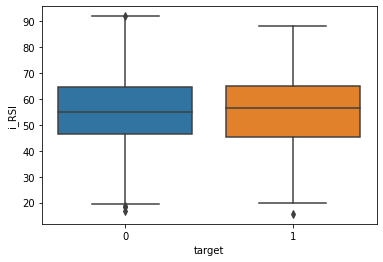

In [ ]:
sns.boxplot(x="target", y="i_RSI", data=df_model_dev, order=[0, 1])

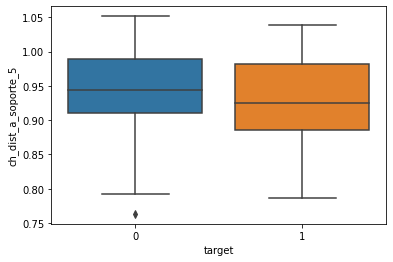

In [ ]:
sns.boxplot(x="target", y="ch_dist_a_soporte_5", data=df_model_test, order=[0, 1])

## Entreno regresión

[01:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


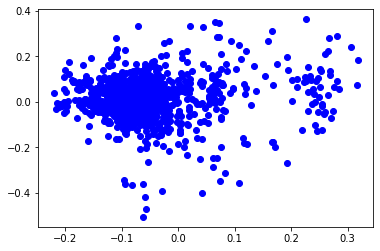

In [ ]:
df_model_dev = df_model[df_model.Date < '2019-01-01']
df_model_test = df_model[df_model.Date >= '2019-01-01']

from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

X_train = np.array(df_model_dev.iloc[:, 3:-1].replace([np.inf, -np.inf], np.nan).fillna(0))
y_train = np.array(df_model_dev['target'])
df_model_test = df_model_test.dropna()
X_test = np.array(df_model_test.iloc[:, 3:-1].replace([np.inf, -np.inf], np.nan).fillna(0))
y_test = np.array(df_model_test.iloc[:, -1])

regr = xg.XGBRegressor(objective ='reg:linear', n_estimators = 800, eta = 0.001, max_depth = 7, seed = 123)
#regr = RandomForestRegressor(max_depth=6, random_state=0)

regr.fit(X_train, y_train)
df_model_test['prediction'] = regr.predict(X_test)
plt.scatter(df_model_test['prediction'], df_model_test['target'], color ='b')


In [ ]:
np.corrcoef(df_model_test['prediction'], df_model_test['target'])


array([[1.        , 0.09406041],
       [0.09406041, 1.        ]])